In [1]:
!pip install seqeval

     |████████████████████████████████| 43 kB 199 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=acaaadaa524b236308aa6d6d98376067c43af4f98932914eb80e50b6524277b6
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
import re
import json
import numpy as np
import torch
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from transformers import BertForTokenClassification, BertTokenizerFast
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
MAX_LEN = 500
EPOCHS = 4
MODEL_PATH = '../input/bert-base-uncased'
TOKENIZER = BertTokenizerFast('../input/bert-base-uncased/vocab.txt', lowercase=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_json('../input/resume-entities-for-ner/Entity Recognition in Resumes.json', lines=True)

In [5]:
df.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [6]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

In [7]:
data = trim_entity_spans(convert_dataturks_to_spacy('../input/resume-entities-for-ner/Entity Recognition in Resumes.json'))

In [8]:
def get_label(offset, labels):
    if offset[0] == 0 and offset[1] == 0:
        return 'O'
    for label in labels:
        if offset[1] >= label[0] and offset[0] <= label[1]:
            return label[2]
    return 'O'

In [9]:
tags_vals = ["UNKNOWN", "O", "Name", "Degree","Skills","College Name","Email Address","Designation","Companies worked at","Graduation Year","Years of Experience","Location"]
tag2idx = {t: i for i, t in enumerate(tags_vals)}
idx2tag = {i:t for i, t in enumerate(tags_vals)}

In [10]:
def process_resume(data, tokenizer, tag2idx, max_len, is_test=False):
    tok = tokenizer.encode_plus(data[0], max_length=max_len, return_offsets_mapping=True)
    curr_sent = {'orig_labels':[], 'labels': []}
    
    padding_length = max_len - len(tok['input_ids'])
    
    if not is_test:
        labels = data[1]['entities']
        labels.reverse()
        for off in tok['offset_mapping']:
            label = get_label(off, labels)
            curr_sent['orig_labels'].append(label)
            curr_sent['labels'].append(tag2idx[label])
        curr_sent['labels'] = curr_sent['labels'] + ([0] * padding_length)
    
    curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
    curr_sent['token_type_ids'] = tok['token_type_ids'] + ([0] * padding_length)
    curr_sent['attention_mask'] = tok['attention_mask'] + ([0] * padding_length)
    return curr_sent

In [11]:
class ResumeDataset(Dataset):
    def __init__(self, resume, tokenizer, tag2idx, max_len, is_test=False):
        self.resume = resume
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.tag2idx = tag2idx
        self.max_len = max_len
    
    def __len__(self):
        return len(self.resume)
    
    def __getitem__(self, idx):
        data = process_resume(self.resume[idx], self.tokenizer, self.tag2idx, self.max_len, self.is_test)
        return {
            'input_ids': torch.tensor(data['input_ids'], dtype=torch.long),
            'token_type_ids': torch.tensor(data['token_type_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(data['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(data['labels'], dtype=torch.long),
            'orig_label': data['orig_labels']
        }

In [12]:
total = len(data)
train_data, val_data = data[:180], data[180:]

In [13]:
train_d = ResumeDataset(train_data, TOKENIZER, tag2idx, MAX_LEN)
val_d = ResumeDataset(val_data, TOKENIZER, tag2idx, MAX_LEN)

In [14]:
train_sampler = RandomSampler(train_d)
train_dl = DataLoader(train_d, sampler=train_sampler, batch_size=8)

val_dl = DataLoader(val_d, batch_size=8)

In [15]:
def get_hyperparameters(model, ff):

    # ff: full_finetuning
    if ff:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "gamma", "beta"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate": 0.01,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate": 0.0,
            },
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    return optimizer_grouped_parameters

In [16]:
def get_special_tokens(tokenizer, tag2idx):
    vocab = tokenizer.get_vocab()
    pad_tok = vocab["[PAD]"]
    sep_tok = vocab["[SEP]"]
    cls_tok = vocab["[CLS]"]
    o_lab = tag2idx["O"]

    return pad_tok, sep_tok, cls_tok, o_lab

In [17]:
def annot_confusion_matrix(valid_tags, pred_tags):

    """
    Create an annotated confusion matrix by adding label
    annotations and formatting to sklearn's `confusion_matrix`.
    """

    # Create header from unique tags
    header = sorted(list(set(valid_tags + pred_tags)))

    # Calculate the actual confusion matrix
    matrix = confusion_matrix(valid_tags, pred_tags, labels=header)

    # Final formatting touches for the string output
    mat_formatted = [header[i] + "\t\t\t" + str(row) for i, row in enumerate(matrix)]
    content = "\t" + " ".join(header) + "\n" + "\n".join(mat_formatted)

    return content

In [18]:
def flat_accuracy(valid_tags, pred_tags):
    return (np.array(valid_tags) == np.array(pred_tags)).mean()

In [19]:
model = BertForTokenClassification.from_pretrained(MODEL_PATH, num_labels=len(tag2idx))
model.to(DEVICE);
optimizer_grouped_parameters = get_hyperparameters(model, True)
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [20]:
MAX_GRAD_NORM = 1.0

In [21]:
def train_and_save_model(
    model,
    tokenizer,
    optimizer,
    epochs,
    idx2tag,
    tag2idx,
    max_grad_norm,
    device,
    train_dataloader,
    valid_dataloader
):

    pad_tok, sep_tok, cls_tok, o_lab = get_special_tokens(tokenizer, tag2idx)
    
    epoch = 0
    val_acc=[]
    ep=[]
    val_loss=[]
    for _ in trange(epochs, desc="Epoch"):
        epoch += 1

        # Training loop
        print("Starting training loop.")
        model.train()
        tr_loss, tr_accuracy = 0, 0
        nb_tr_examples, nb_tr_steps = 0, 0
        tr_preds, tr_labels = [], []

        for step, batch in enumerate(train_dataloader):
            # Add batch to gpu
            
            # batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            # Forward pass
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss, tr_logits = outputs[:2]

            # Backward pass
            loss.backward()

            # Compute train loss
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

            # Subset out unwanted predictions on CLS/PAD/SEP tokens
            preds_mask = (
                (b_input_ids != cls_tok)
                & (b_input_ids != pad_tok)
                & (b_input_ids != sep_tok)
            )

            tr_logits = tr_logits.cpu().detach().numpy()
            tr_label_ids = torch.masked_select(b_labels, (preds_mask == 1))
            preds_mask = preds_mask.cpu().detach().numpy()
            tr_batch_preds = np.argmax(tr_logits[preds_mask.squeeze()], axis=1)
            tr_batch_labels = tr_label_ids.to("cpu").numpy()
            tr_preds.extend(tr_batch_preds)
            tr_labels.extend(tr_batch_labels)

            # Compute training accuracy
            tmp_tr_accuracy = flat_accuracy(tr_batch_labels, tr_batch_preds)
            tr_accuracy += tmp_tr_accuracy

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=max_grad_norm
            )

            # Update parameters
            optimizer.step()
            model.zero_grad()

        tr_loss = tr_loss / nb_tr_steps
        tr_accuracy = tr_accuracy / nb_tr_steps

        # Print training loss and accuracy per epoch
        print(f"Train loss: {tr_loss}")
        print(f"Train accuracy: {tr_accuracy}")
        
        
        """
        Validation loop
        """ 
        print("Starting validation loop.")

        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions, true_labels = [], []

        for batch in valid_dataloader:

            b_input_ids, b_input_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                )
                tmp_eval_loss, logits = outputs[:2]

            # Subset out unwanted predictions on CLS/PAD/SEP tokens
            preds_mask = (
                (b_input_ids != cls_tok)
                & (b_input_ids != pad_tok)
                & (b_input_ids != sep_tok)
            )

            logits = logits.cpu().detach().numpy()
            label_ids = torch.masked_select(b_labels, (preds_mask == 1))
            preds_mask = preds_mask.cpu().detach().numpy()
            val_batch_preds = np.argmax(logits[preds_mask.squeeze()], axis=1)
            val_batch_labels = label_ids.to("cpu").numpy()
            predictions.extend(val_batch_preds)
            true_labels.extend(val_batch_labels)

            tmp_eval_accuracy = flat_accuracy(val_batch_labels, val_batch_preds)

            eval_loss += tmp_eval_loss.mean().item()
            eval_accuracy += tmp_eval_accuracy

            nb_eval_examples += b_input_ids.size(0)
            nb_eval_steps += 1

        # Evaluate loss, acc, conf. matrix, and class. report on devset
        pred_tags = [idx2tag[i] for i in predictions]
        valid_tags = [idx2tag[i] for i in true_labels]
        cl_report = classification_report([valid_tags], [pred_tags])
        conf_mat = annot_confusion_matrix(valid_tags, pred_tags)
        eval_loss = eval_loss / nb_eval_steps
        eval_accuracy = eval_accuracy / nb_eval_steps

        # Report metrics
        print(f"Validation loss: {eval_loss}")
        print(f"Validation Accuracy: {eval_accuracy}")
        print(f"Classification Report:\n {cl_report}")
        print(f"Confusion Matrix:\n {conf_mat}")
        val_acc.append(eval_accuracy)
        ep.append(epoch)
        val_loss.append(eval_loss)
    
    plt.plot(ep, val_acc, 'g', label='Validation accuracy')
    #plt.plot(ep, val_loss, 'b', label='Validation loss')
    plt.title('Validation acuuracy ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()    

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Starting training loop.
Train loss: 0.9266693695731785
Train accuracy: 0.7790637834006218
Starting validation loop.


/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Name seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Designation seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Location seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Email Address seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Companies worked at seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/met

Validation loss: 0.6158261179924012
Validation Accuracy: 0.8309217125108124
Classification Report:
                     precision    recall  f1-score   support

               ame       0.00      0.00      0.00        41
ears of Experience       0.00      0.00      0.00         5
             egree       0.00      0.00      0.00        35
        esignation       0.00      0.00      0.00        89
             kills       1.00      0.01      0.01       869
      mail Address       0.56      0.75      0.64      1130
           ocation       0.00      0.00      0.00        54
       ollege Name       0.00      0.00      0.00        33
ompanies worked at       0.00      0.00      0.00        59
    raduation Year       0.00      0.00      0.00        16

         micro avg       0.56      0.36      0.44      2331
         macro avg       0.16      0.08      0.07      2331
      weighted avg       0.65      0.36      0.32      2331

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:  50%|█████     | 2/4 [00:25<00:26, 13.07s/it]

Validation loss: 0.5686264514923096
Validation Accuracy: 0.7747564766903574
Classification Report:
                     precision    recall  f1-score   support

               ame       0.08      0.20      0.11        41
ears of Experience       0.00      0.00      0.00         5
             egree       0.00      0.00      0.00        35
        esignation       0.09      0.03      0.05        92
             kills       0.33      0.72      0.45       869
      mail Address       0.53      0.95      0.68      1130
           ocation       0.15      0.30      0.20        53
       ollege Name       0.01      0.03      0.01        33
ompanies worked at       0.00      0.00      0.00        60
    raduation Year       0.00      0.00      0.00        16

         micro avg       0.40      0.74      0.52      2334
         macro avg       0.12      0.22      0.15      2334
      weighted avg       0.39      0.74      0.51      2334

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:  75%|███████▌  | 3/4 [00:38<00:12, 12.93s/it]

Validation loss: 0.34445019364356994
Validation Accuracy: 0.8875406728092011
Classification Report:
                     precision    recall  f1-score   support

               ame       0.67      0.76      0.71        41
ears of Experience       0.00      0.00      0.00         5
             egree       0.07      0.09      0.08        35
        esignation       0.16      0.16      0.16        89
             kills       0.65      0.60      0.63       869
      mail Address       0.88      0.75      0.81      1130
           ocation       0.47      0.46      0.47        54
       ollege Name       0.06      0.12      0.08        33
ompanies worked at       0.08      0.08      0.08        59
    raduation Year       0.00      0.00      0.00        16

         micro avg       0.68      0.62      0.65      2331
         macro avg       0.30      0.30      0.30      2331
      weighted avg       0.70      0.62      0.66      2331

Confusion Matrix:
 	College Name Companies worked at Deg

Epoch: 100%|██████████| 4/4 [00:50<00:00, 12.71s/it]

Validation loss: 0.3432180047035217
Validation Accuracy: 0.8736896201028488
Classification Report:
                     precision    recall  f1-score   support

               ame       0.88      0.90      0.89        41
ears of Experience       0.00      0.00      0.00         5
             egree       0.11      0.11      0.11        35
        esignation       0.16      0.22      0.19        92
             kills       0.53      0.72      0.61       869
      mail Address       0.88      0.75      0.81      1130
           ocation       0.56      0.62      0.59        53
       ollege Name       0.07      0.18      0.10        33
ompanies worked at       0.16      0.38      0.22        60
    raduation Year       0.00      0.00      0.00        16

         micro avg       0.61      0.68      0.64      2334
         macro avg       0.34      0.39      0.35      2334
      weighted avg       0.66      0.68      0.67      2334

Confusion Matrix:
 	College Name Companies worked at Degr

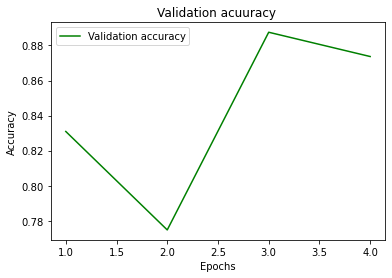

In [22]:
train_and_save_model(
    model, 
    TOKENIZER, 
    optimizer, 
    EPOCHS, 
    idx2tag, 
    tag2idx, 
    MAX_GRAD_NORM, 
    DEVICE, 
    train_dl, 
    val_dl
)

In [23]:
torch.save(
    {
        "epoch": EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    'model_e10.tar',
)

In [24]:
MAX_LEN = 500
EPOCHS = 6
DEVICE = torch.device("cpu")
MODEL_PATH = '../input/bert-base-uncased'
STATE_DICT = torch.load('../working/model_e10.tar', map_location=DEVICE)
TOKENIZER = BertTokenizerFast('../input/bert-base-uncased/vocab.txt', lowercase=True)
MODEL = BertForTokenClassification.from_pretrained(MODEL_PATH, state_dict=STATE_DICT['model_state_dict'], num_labels=12)

In [25]:
def process_resume2(text, tokenizer, max_len):
    tok = tokenizer.encode_plus(text, max_length=max_len, return_offsets_mapping=True)
    
    curr_sent = dict()
    
    padding_length = max_len - len(tok['input_ids'])
        
    curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
    curr_sent['token_type_ids'] = tok['token_type_ids'] + ([0] * padding_length)
    curr_sent['attention_mask'] = tok['attention_mask'] + ([0] * padding_length)
    
    final_data = {
        'input_ids': torch.tensor(curr_sent['input_ids'], dtype=torch.long),
        'token_type_ids': torch.tensor(curr_sent['token_type_ids'], dtype=torch.long),
        'attention_mask': torch.tensor(curr_sent['attention_mask'], dtype=torch.long),
        'offset_mapping': tok['offset_mapping']
    }
    
    return final_data

In [26]:
tags_vals = ["UNKNOWN", "O", "Name", "Degree","Skills","College Name","Email Address","Designation","Companies worked at","Graduation Year","Years of Experience","Location"]
tag2idx = {t: i for i, t in enumerate(tags_vals)}
idx2tag = {i:t for i, t in enumerate(tags_vals)}

In [27]:
model = MODEL
model.to(DEVICE);

In [28]:
def predict(model, tokenizer, idx2tag, tag2idx, device, test_resume):
    model.eval()
    data = process_resume2(test_resume, tokenizer, MAX_LEN)
    input_ids, input_mask = data['input_ids'].unsqueeze(0), data['attention_mask'].unsqueeze(0)
    labels = torch.tensor([1] * input_ids.size(0), dtype=torch.long).unsqueeze(0)
    with torch.no_grad():
        outputs = model(
            input_ids,
            token_type_ids=None,
            attention_mask=input_mask,
            labels=labels,
        )
        tmp_eval_loss, logits = outputs[:2]
    
    logits = logits.cpu().detach().numpy()
    label_ids = np.argmax(logits, axis=2)
    
    entities = []
    for label_id, offset in zip(label_ids[0], data['offset_mapping']):
        curr_id = idx2tag[label_id]
        curr_start = offset[0]
        curr_end = offset[1]
        if curr_id != 'O':
            if len(entities) > 0 and entities[-1]['entity'] == curr_id and curr_start - entities[-1]['end'] in [0, 1]:
                entities[-1]['end'] = curr_end
            else:
                entities.append({'entity': curr_id, 'start': curr_start, 'end':curr_end})
    for ent in entities:
        ent['text'] = test_resume[ent['start']:ent['end']]
    return entities

In [29]:
!pip install pdfminer.six

     |████████████████████████████████| 5.6 MB 5.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [30]:
from pdfminer.high_level import extract_text

In [31]:
text = extract_text('../input/unnati-resume-2/unnati resume.pdf')
resume_text1 = text.replace("\n", " ")
resume_text1

'UNNATI RUSIA  Jabalpur Engineering College , Jabalpur(M.P) [ unnatirusia154@gmail.com  (cid:211) +91-9074185521  EXPERIENCE, MOOCS AND TRAINING  EDUCATION  (cid:135) github.com/UnnatiRusia  ﬂ linkedin.com/in/unnati-rusia/  EDRAHI Edtech Pvt. Ltd. Research Assistant Intern (cid:17) May 2020-July 2020  • Market research , Data Analysis, Brand endorsement and Campaign De-  sign,Push Marketing, Designing Marketing strategy.  • Competitor Research, Product Design test , User Persona Research, MVP  development and designing.  • Committed to ﬁnd product market ﬁt. Algorithm Toolboox by University of California San Diego MOOCs (cid:17) April 2020-May 2020  • Covers basic algorithmic techniques and ideas for computational problems  arising frequently in practical applications.  • practice solving computational problems, designing new algorithms, and im-  plementing solutions eﬃciently.  Data Analysis in Python by IBM MOOCs (cid:17) April 2020  • learn how to prepare data for analysis, perform 

In [32]:
text = extract_text('../input/unnati-resume-2/unnati resume.pdf')
resume_text1 = text.replace("\n", " ")
resume_text1
text = extract_text('../input/shashank-resume/shashank Bajpai-Bca 2021 AUR - Shashank Bajpai.pdf')
resume_text2 = text.replace("\n", " ")
resume_text2

'SHASHANK BAJPAI                                                                                   BCA                                                +918564996642   Email- shashank.bajpai@student.amity.edu  Skype ID – live:.cid.e0cec82567bb4ab3  https://www.linkedin.com/in/shashank-bajpai-810aa7184/      A21704818005                                                            PROFILE HIGHLIGHTS        •  Excellent in client relationship and client retention strategy  •  Practical experience of finacel software used in bank  •  Practical exposure in research   •  Organization:   MOHANI TEA LEAVES PVT.LTD  •  Title: Record management       INTERNSHIP EXPERIENCE                      EDUCATIONAL QUALIFICATION      Qualification   University/ School   Graduating Year   Percentage/CGPA         BCA 3rd  year   Amity University, Rajasthan   12th   10th             SARASWATI SHIKSHA SADAN ,INTER  COLLEGE,KANPUR  SARASWATI SHIKSHA SADAN ,INTER  COLLEGE,KANPUR      2021   2018   2016             

In [33]:
entities1 = predict(model, TOKENIZER, idx2tag, tag2idx, DEVICE, resume_text1)
entities2 = predict(model, TOKENIZER, idx2tag, tag2idx, DEVICE, resume_text2)

In [34]:
for i in entities1:
    print(i['entity'], '-', i['text']) # abhi 4 epoch

Name - UNNATI RUSIA
Name - Ja
College Name - balpur Engineering College ,
Location - Ja
Location - pur
College Name - M
Degree - .
College Name - P
Email Address - unnat
Name - irus
Email Address - ia154@gma
Name - il
Email Address - .com
Email Address - +91-907418552
Companies worked at - IBM
Skills - Leadership skills, Teamwork, Problem-solving Ethics, Work Ethics
Skills - Matrix
Skills - java
Degree - B.Tech in
Degree - Technology
College Name - Anoop Public School
Skills - 84.
College Name - Rani LaxmiBai Public School
Skills - SKILLS
Skills - Programming/Scripting •Java(basic) •Python •Node.js •JavaScript •C/C++ •Html •CSS •Bootstrap •Data Structures and


In [35]:
for i in entities2:
    print(i['entity'], '-', i['text']) # abhi 4 epoch

Name - SHASHANK BAJPAI
Name - BC
Designation - A
Email Address - 918564996642
Name - shashank.bajpa
Name - ami
College Name - ty
Designation - .
Email Address - e0cec82567
Email Address - 4
College Name - Amity University
College Name - 10th
College Name - SARASWATI SHIKSHA SADAN ,INTER
College Name - COLLEGE
College Name - SARASWATI SHIKSHA SADAN ,INTER
College Name - COLLEGE
Skills - 62.6%
Skills - 72%
Skills - TECHNICAL SKILLS
Skills - •
Skills - C, C++ , DBMS, HTML,PYTHON
Skills - ACHIEVEMENTS
Skills - •
Skills - Languages known: Foreign language (with proficiency level) German
Skills - REFERENCES
Skills - On Demand
Skills - 2
